In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers import RMSprop


import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd

%matplotlib inline


# LeNet-5

In [0]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(logs.get('accuracy') >= 0.97):
            print("Accuracy is above 97%, stopping.")
            self.model.stop_training = True

In [33]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


In [0]:
paddings = tf.constant([[2, 2], [2, 2], [0, 0]])
def normalize(images, labels):
  images = tf.pad(images, paddings)
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

In [0]:
lenet5 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, (5,5), padding='same', activation='relu', input_shape=(32, 32, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(16, (5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),

    tf.keras.layers.Dense(10,  activation='softmax')
])

In [0]:
lenet5.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
lenet5.summary()


In [0]:
BATCH_SIZE = 256

callbacks = myCallback()

train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

lenet_history = lenet5.fit(train_dataset, 
                           epochs=20, 
                           steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

In [38]:
test_loss, test_accuracy = lenet5.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

 39/313 [==>...........................] - ETA: 18s - loss: 0.2885 - accuracy: 0.9025WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 313 batches). You may need to use the repeat() function when building your dataset.


 40/313 [==>...........................] - 3s 68ms/step - loss: 0.2889 - accuracy: 0.9025
Accuracy on test dataset: 0.9024999737739563


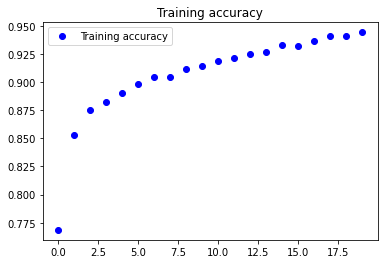

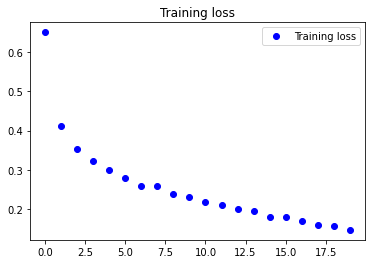

In [39]:
lenet5.save('lenet5.h5')
accuracy = lenet_history.history['accuracy']
#val_accuracy = lenet_history.history['val_accuracy']
loss = lenet_history.history['loss']
#val_loss = lenet_history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
#plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.legend()
plt.show()

# 1 Layer CNN

In [0]:
data_train, data_test = fashion_mnist.load_data()

X = np.array(data_train[0])
y = to_categorical(np.array(data_train[1]))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

X_test = np.array(data_test[0])
y_test = to_categorical(np.array(data_test[1]))

In [0]:
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_train = X_train.astype('float32')
X_train /= 255

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_test = X_test.astype('float32')
X_test /= 255

X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
X_val = X_val.astype('float32')
X_val /= 255

In [0]:
singleLayer = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(128, activation='relu'),

        tf.keras.layers.Dense(10, activation='softmax')
])

In [24]:
# singleLayer.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])
singleLayer.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])
singleLayer.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               692352    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
________________________________________________

In [0]:
# Without augmentation
singleLayer_history = singleLayer.fit(X_train, y_train,
          batch_size=256,
          epochs=20,
          verbose=1,
          validation_data=(X_val, y_val))

In [0]:
# With augmentation
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(rotation_range=8, 
                         width_shift_range=0.08, 
                         shear_range=0.3,
                         height_shift_range=0.08, 
                         zoom_range=0.08)

batches = gen.flow(X_train, y_train, batch_size=256)
val_batches = gen.flow(X_val, y_val, batch_size=256)

In [0]:
singleLayer_history = singleLayer.fit_generator(batches, 
                                                steps_per_epoch=48000//256, 
                                                epochs=50,
                                                validation_data=val_batches, 
                                                validation_steps=12000//256)

In [15]:
test_loss, test_accuracy = singleLayer.evaluate(X_test, y_test)
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 0.2813 - accuracy: 0.9126
Accuracy on test dataset: 0.9125999808311462


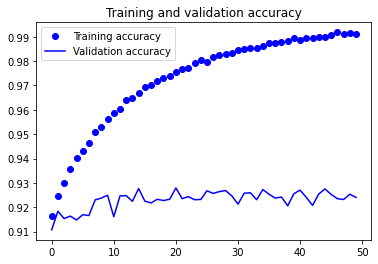

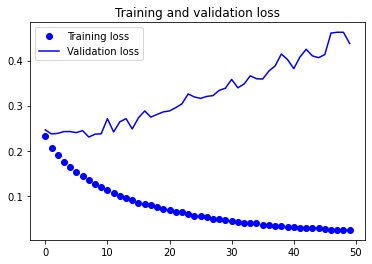

In [75]:
singleLayer.save('singleLayer.h5')

accuracy = singleLayer_history.history['accuracy']
val_accuracy = singleLayer_history.history['val_accuracy']
loss = singleLayer_history.history['loss']
val_loss = singleLayer_history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# 4 Layer CNN

In [0]:
data_train, data_test = fashion_mnist.load_data()

X = np.array(data_train[0])
y = to_categorical(np.array(data_train[1]))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

X_test = np.array(data_test[0])
y_test = to_categorical(np.array(data_test[1]))

In [0]:
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)
paddings = tf.constant([[2, 2], [2, 2], [0, 0]])


X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_train = X_train.astype('float32')
X_train /= 255

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_test = X_test.astype('float32')
X_test /= 255

X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
X_val = X_val.astype('float32')
X_val /= 255

In [0]:
fourleLayer = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),                        
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(10, activation='softmax')
])

In [57]:
fourleLayer.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
fourleLayer.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_18 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_19 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 10, 10, 64)       

In [0]:
# Without data augmentation
epochs = 20
batch_size = 256

fourleLayer_history = fourleLayer.fit(X_train, y_train,
                                      batch_size=batch_size,
                                      epochs=50,
                                      validation_data=(X_test, y_test),
                                      shuffle=True,
                                      callbacks = [callbacks])

In [58]:

# With data augmentation
epochs = 20
batch_size = 32

train_datagen = ImageDataGenerator(rotation_range=8, 
                                  width_shift_range=0.08, 
                                  shear_range=0.3,
                                  height_shift_range=0.08, 
                                  zoom_range=0.08)

train_datagen.fit(X_train)

fourleLayer_history = fourleLayer.fit_generator(train_datagen.flow(X_train, y_train,
                                                batch_size=batch_size),
                                                epochs=epochs,
                                                validation_data=(X_test, y_test),
                                                steps_per_epoch=X_train.shape[0] // batch_size,
                                                workers=4)

Epoch 1/20
1500/1500 [==============================] - 41s 27ms/step - loss: 0.8005 - accuracy: 0.7156 - val_loss: 0.4566 - val_accuracy: 0.8260
Epoch 2/20
1500/1500 [==============================] - 41s 27ms/step - loss: 0.5473 - accuracy: 0.7987 - val_loss: 0.4164 - val_accuracy: 0.8477
Epoch 3/20
1500/1500 [==============================] - 41s 27ms/step - loss: 0.4790 - accuracy: 0.8257 - val_loss: 0.4036 - val_accuracy: 0.8310
Epoch 4/20
1500/1500 [==============================] - 41s 27ms/step - loss: 0.4390 - accuracy: 0.8403 - val_loss: 0.3535 - val_accuracy: 0.8670
Epoch 5/20
1500/1500 [==============================] - 41s 27ms/step - loss: 0.4173 - accuracy: 0.8497 - val_loss: 0.2962 - val_accuracy: 0.8904
Epoch 6/20
1500/1500 [==============================] - 40s 27ms/step - loss: 0.3943 - accuracy: 0.8572 - val_loss: 0.2839 - val_accuracy: 0.8958
Epoch 7/20
1500/1500 [==============================] - 41s 27ms/step - loss: 0.3786 - accuracy: 0.8654 - val_loss: 0.2785 -

In [59]:
test_loss, test_accuracy = fourleLayer.evaluate(X_test, y_test)
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 2s 5ms/step - loss: 0.2267 - accuracy: 0.9167
Accuracy on test dataset: 0.916700005531311


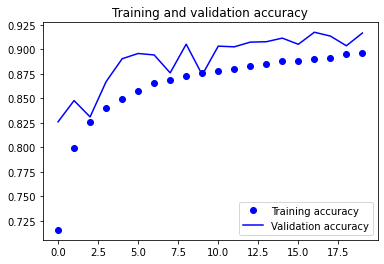

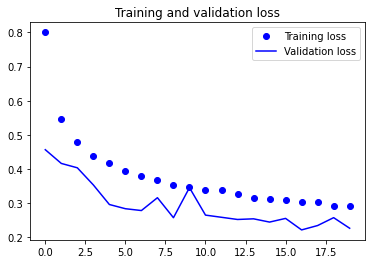

In [60]:
fourleLayer.save('fourleLayer.h5')

accuracy = fourleLayer_history.history['accuracy']
val_accuracy = fourleLayer_history.history['val_accuracy']
loss = fourleLayer_history.history['loss']
val_loss = fourleLayer_history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()